In [1]:
import sys
import time
import pickle
import numpy as np
import pandas as pd

from multiprocessing import Pool

from skimage import io
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras 
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16

from scripts.image import load_image

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
img_rows, img_cols = 224, 224

In [3]:
images_preloaded = True
try:
    with open('data/images.pickle', 'rb') as handle:
        features, labels =  pickle.load(handle)
except:
    images_preloaded = False

In [4]:
# load images into memory
if(not images_preloaded):
    with open('data/tmdb_info.pickle', 'rb') as handle:
        tmdb_dict =  pickle.load(handle)
    with Pool(6) as p:
        rs = p.map_async(load_image, list(tmdb_dict.keys()))
        p.close()
        while (True):
            if (rs.ready()): break
            remaining = rs._number_left
            print("Waiting for", remaining, "tasks to complete...")
            time.sleep(10)

Waiting for 24 tasks to complete...
Waiting for 24 tasks to complete...
Waiting for 23 tasks to complete...
Waiting for 19 tasks to complete...
Waiting for 15 tasks to complete...
Waiting for 11 tasks to complete...
Waiting for 8 tasks to complete...
Waiting for 5 tasks to complete...


In [5]:
# extract labes for the loaded images
if(not images_preloaded):
    labels = []
    features = []
    for r in rs.get():
        if(r[1] is not None):
            d = tmdb_dict[r[0]].__dict__
            labels.append([g['name']  for g in   d['genres']])
            features.append(r[1])
    features = np.asarray(features)
    rs = None
    tmdb_dict = None

In [6]:
# create the labels vector
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)
output_size = y.shape[1]
print('label matrix shape:', y.shape)

label matrix shape: (58827, 20)


In [7]:
# split into test / train data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.25, random_state = 442)

In [8]:
print('Train label matrix shape:', y_train.shape)
print('Train predictor matrix shape:', X_train.shape)
print('Test label matrix shape:', y_test.shape)
print('Test predictor matrix shape:', X_test.shape)

Train label matrix shape: (44120, 20)
Train predictor matrix shape: (44120, 224, 224, 3)
Test label matrix shape: (14707, 20)
Test predictor matrix shape: (14707, 224, 224, 3)


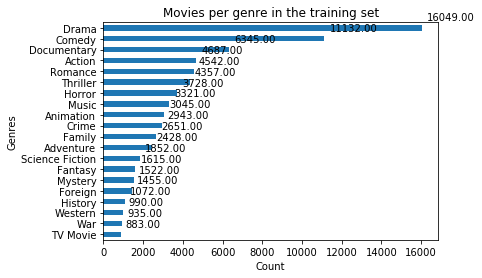

In [9]:
label_df = pd.DataFrame(y_train)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the training set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

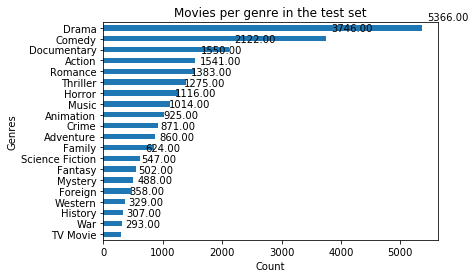

In [10]:
label_df = pd.DataFrame(y_test)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the test set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

In [14]:
earlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 0, verbose = 0, mode = 'auto')
reduceLROnPlateau = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)

In [25]:
sgd = SGD(lr = 0.1, decay = 1e-6, momentum = 0.9, nesterov = True)

In [22]:
vgg16 = VGG16()
x = Dense(output_size, activation='sigmoid', name='predictions')(vgg16.layers[-2].output)
model = Model(inputs = vgg16.inputs, outputs = x)
model.summary()

In [26]:
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size = 64, 
    epochs = 20, 
    verbose = 1,
    validation_data = (X_test, y_test),
    callbacks = [earlyStopping]
)

Train on 44120 samples, validate on 14707 samples
Epoch 1/20
12032/44120 [=======>......................] - ETA: 1564s - loss: 8.0283 - acc: 0.1056

In [ ]:
y_pred_proba = model.predict(X_test)
y_pred_test = np.zeros(y_pred_proba.shape)
y_pred_test[y_pred_proba > 0.5] = 1

In [ ]:
print(classification_report(y_test, y_pred_test, target_names = mlb.classes_))

In [ ]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")